In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import dpp

from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
# from umap import UMAP
import seaborn as sns
sns.set_style('whitegrid')
torch.set_default_tensor_type(torch.cuda.FloatTensor) 

# Generate synthetic data

In [2]:
np.random.seed(123)
n_samples = 1024
n_sequences = 32
poisson = [dpp.gen.poisson.sample(n_samples=n_samples) for _ in range(n_sequences)]
renewal = [dpp.gen.renewal.sample(n_samples) for _ in range(n_sequences)]
self_correcting = [dpp.gen.self_correcting.sample(n_samples) for _ in range(n_sequences)]
hawkes1 = [dpp.gen.hawkes.hawkes1(n_samples)[0] for _ in range(n_sequences)]
hawkes2 = [dpp.gen.hawkes.hawkes2(n_samples)[0] for _ in range(n_sequences)]

all_arrival = poisson + renewal + self_correcting + hawkes1 + hawkes2
all_deltas = [dpp.utils.get_inter_times(t) for t in all_arrival]

dataset = dpp.data.SequenceDataset(all_deltas) 

In [3]:
d_train, d_val, d_test = dataset.train_val_test_split_each() 
mean_in, std_in = d_train.get_mean_std_in()
d_train = d_train.normalize(mean_in, std_in)
d_val = d_val.normalize(mean_in, std_in)
d_test = d_test.normalize(mean_in, std_in)  

In [4]:
d_train.break_down_long_sequences(128)
collate = dpp.data.collate
dl_train = torch.utils.data.DataLoader(d_train, batch_size=64, shuffle=True, collate_fn=collate)
dl_val = torch.utils.data.DataLoader(d_val, batch_size=1, shuffle=False, collate_fn=collate)
dl_test = torch.utils.data.DataLoader(d_test, batch_size=1, shuffle=False, collate_fn=collate)  

# Define the model

In [5]:
config = dpp.model.ModelConfig(
    use_history=True,
    history_size=64,
    use_embedding=True,
    embedding_size=64,
    num_embeddings=len(dataset),
)

shift_init, scale_init = d_train.get_log_mean_std_out()
decoder = dpp.decoders.LogNormMix(config, hypernet_hidden_sizes=[], 
                              shift_init=shift_init, scale_init=scale_init) 
model = dpp.model.Model(config, decoder) 

opt = torch.optim.Adam(model.parameters(),
                       weight_decay=1e-5,
                       lr=1e-3)  

In [6]:
def get_total_loss(loader):
    loader_log_prob, loader_lengths = [], []
    for input in loader:
        loader_log_prob.append(model.log_prob(input).detach())
        loader_lengths.append(input.length.detach())
    return -model.aggregate(loader_log_prob, loader_lengths)  

In [7]:
max_epochs = 1000
display_step = 25
patience = 100  

# Training the model
### Pre-train the embeddings

In [8]:
model.use_history(False)
model.use_embedding(True)  

In [9]:
impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []

for epoch in range(max_epochs):
    model.train()
    for input in dl_train:
        opt.zero_grad()
        log_prob = model.log_prob(input)
        loss = -model.aggregate(log_prob, input.length)
        loss.backward()
        opt.step()

    model.eval()
    loss_val = get_total_loss(dl_val)
    training_val_losses.append(loss_val.item())

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val.item()
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val.item()
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:4d}, loss_train_last_batch = {loss:.4f}, loss_val = {loss_val:.4f}")

Epoch   25, loss_train_last_batch = 0.6578, loss_val = 0.5921
Epoch   50, loss_train_last_batch = 0.4769, loss_val = 0.5901
Epoch   75, loss_train_last_batch = 0.5849, loss_val = 0.5908
Epoch  100, loss_train_last_batch = 0.5061, loss_val = 0.5914
Epoch  125, loss_train_last_batch = 0.5089, loss_val = 0.5921
Breaking due to early stopping at epoch 149


### Finish training with history

In [10]:
model.use_history(True)
model.use_embedding(True)  

In [11]:
model.load_state_dict(best_model)
impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())

for epoch in range(max_epochs):
    model.train()
    for input in dl_train:
        opt.zero_grad()
        log_prob = model.log_prob(input)
        loss = -model.aggregate(log_prob, input.length)
        loss.backward()
        opt.step()

    model.eval()
    loss_val = get_total_loss(dl_val)
    training_val_losses.append(loss_val.item())

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val.item()
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val.item()
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:4d}, loss_train = {loss:.4f}, loss_val = {loss_val:.4f}")  

Epoch   25, loss_train = 0.5782, loss_val = 0.5379
Epoch   50, loss_train = 0.6117, loss_val = 0.5321
Epoch   75, loss_train = 0.5734, loss_val = 0.5409
Epoch  100, loss_train = 0.6134, loss_val = 0.5588
Epoch  125, loss_train = 0.4832, loss_val = 0.5785
Breaking due to early stopping at epoch 139


# Visualize the learned embeddings

In [12]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('colorblind', 5).as_hex())
colors = np.zeros(n_sequences * 5)
for i in range(5):
    colors[np.arange(i*n_sequences, (i + 1)*n_sequences)] = i

def plot_embeddings():
    from sklearn.manifold import TSNE

    if config.embedding_size == 2:
        z = model.embedding.weight.cpu().detach().numpy()
    else:
        x = model.embedding.weight.cpu().detach().numpy()
        # z = UMAP().fit_transform(x)
        z = TSNE().fit_transform(x)

    fig, ax = plt.subplots(figsize=(3.8, 2.5))
    scatter = ax.scatter(z[:, 0], z[:, 1], c=colors, alpha=0.5, cmap=cmap)
    a, b = scatter.legend_elements()
    legend1 = ax.legend(a, ['Poisson', 'Renewal', 'Self-correcting', 'Hawkes1', 'Hawkes2'], bbox_to_anchor=(1.0, 1.0))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('t-SNE component 1')
    ax.set_ylabel('t-SNE component 2')
    plt.tight_layout()


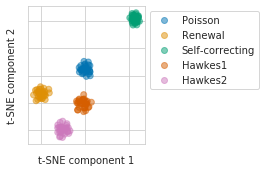

In [13]:
plot_embeddings()